In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

# import sys
# sys.path.append('/content/PINN-CGM-1/simglucose')

from collections import namedtuple
from simglucose.patient.t1dpatient import T1DPatient

from simglucose.sensor.cgm import CGMSensor
from simglucose.simulation.env import T1DSimEnv
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.sim_engine import SimObj, sim
from simglucose.simulation.scenario import CustomScenario
from simglucose.controller.basal_bolus_ctrller import BBController

from tqdm.notebook import tqdm, trange
from deap import base, creator, tools, cma

from data import C3RData, interpolate
from utils import dt2int

import pyswarms as ps

import logging

In [2]:
# config
GLOBAL_SEED = 0
RESULTS_PATH = "results/"

# better plots
sns.set()

# tqdm
tqdm.pandas()

# logger
logger = logging.getLogger()
logger.disabled = True

In [3]:
# load dataset
c3r = C3RData(data_dir="data/")

# get data for a certain case
deident_id = 2
from_dt = f"2014-05-05 00:00:00"
to_dt = f"2014-05-08 00:00:00"


# destructure data
cgm_data, meal_data, insulin_data = c3r.get_case(deident_id, from_dt, to_dt)
data_t, data_CGM, data_CHO, data_insulin = interpolate(cgm_data, meal_data, insulin_data)

# normalize time
data_t -= data_t[0]

# scale down to minutes
data_t = data_t / 60.0

# clean
data_CHO = np.nan_to_num(data_CHO, nan=data_CHO[0])
data_insulin = np.nan_to_num(data_insulin, nan=data_insulin[0])

In [4]:
# load test data
test_from_dt = f"2014-05-09 00:00:00"
test_to_dt = f"2014-05-10 00:00:00"

# destructure data
test_cgm_data, test_meal_data, test_insulin_data = c3r.get_case(deident_id, test_from_dt, test_to_dt)
test_data_t, test_data_CGM, test_data_CHO, test_data_insulin = interpolate(test_cgm_data, test_meal_data, test_insulin_data)

# normalize time
test_data_t -= test_data_t[0]

# scale down to minutes
test_data_t = test_data_t / 60.0

# clean
test_data_CHO = np.nan_to_num(test_data_CHO, nan=test_data_CHO[0])
test_data_insulin = np.nan_to_num(test_data_insulin, nan=test_data_insulin[0])

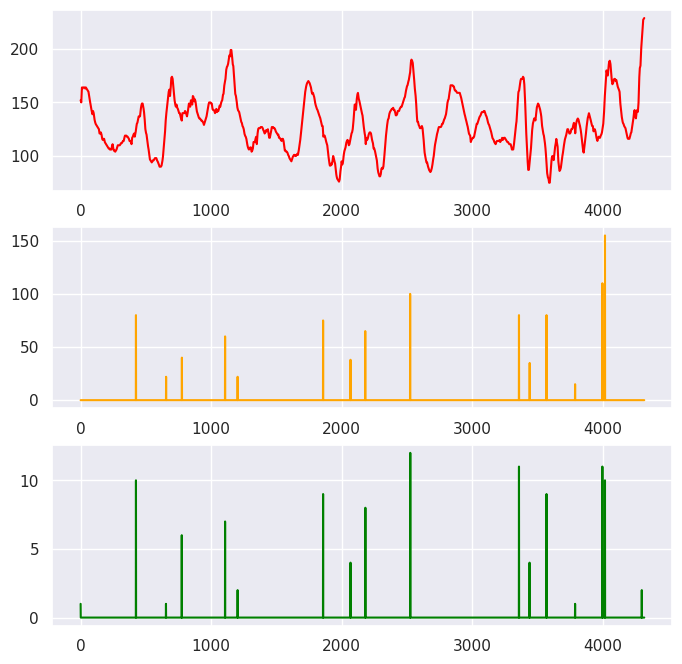

In [5]:
# visualize data
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(data_t, data_CGM, label="CGM", color="red")
plt.subplot(3, 1, 2)
plt.plot(data_t, data_CHO, label="CHO", color="orange")
plt.subplot(3, 1, 3)
plt.plot(data_t, data_insulin, label="insulin", color="green")
plt.show()

In [6]:
# required data structures
Action = namedtuple("patient_action", ['CHO', 'insulin'])

In [7]:
# load parameters
orig_params = pd.read_csv("parameters/vpatient_params.csv")
nominal_params = orig_params.mean(numeric_only=True)
est_params = ["kp2", "k1", "k2", "kp1", "ki", "ke1", "kmax", "kmin", "kabs", "kp3"]

# constrain parameters to be within the range
adult_params = orig_params[orig_params.Name.str.contains("adult")].loc[:, est_params]
# p_range = np.stack([adult_params.min(), adult_params.max()], axis=1)
rm = 10
p_range = np.stack([adult_params.mean() / rm, adult_params.mean() * rm], axis=1)
def constrain_params(p):
    return ((np.tanh(p) + 1) / 2) * (p_range[:, 1] - p_range[:, 0]) + p_range[:, 0]

# construct parameter dict
def construct_params(p):
    # p = [kp2, k1, k2, kp1, ki, ke1, kmax, kmin, kabs, kp3]
    return pd.Series({
        **nominal_params.drop("i").to_dict(),
        **dict(zip(est_params, constrain_params(p))),
    })

In [8]:
# time
t_span = (data_t[0], data_t[-1])
t_eval = data_t

# initial conditions
u0 = nominal_params.iloc[2:15].to_numpy()

def output(params):
    patient = T1DPatient.withParams(params)

    t_trace = t_eval # np.arange(*t_span)
    BG_trace = []
    # dx_trace = []

    for t in t_trace:
        # get current action
        t_mask = np.abs(data_t - t).argmin()
        action = Action(CHO=data_CHO[t_mask], insulin=data_insulin[t_mask])

        # track variables
        BG_trace.append(patient.observation.Gsub)
        # dx_trace.append(patient.derivative)

        patient.step(action)

    BG_trace = np.array(BG_trace)
    # dx_trace = np.array(derivatives)

    return t_trace, BG_trace #, dx_trace

# TODO: merge with output function
def test_output(params):
    patient = T1DPatient.withParams(params)

    t_trace = test_data_t # np.arange(*t_span)
    BG_trace = []
    # dx_trace = []

    for t in t_trace:
        # get current action
        t_mask = np.abs(test_data_t - t).argmin()
        action = Action(CHO=test_data_CHO[t_mask], insulin=test_data_insulin[t_mask])

        # track variables
        BG_trace.append(patient.observation.Gsub)
        # dx_trace.append(patient.derivative)

        patient.step(action)

    BG_trace = np.array(BG_trace)
    # dx_trace = np.array(derivatives)

    return t_trace, BG_trace #, dx_trace

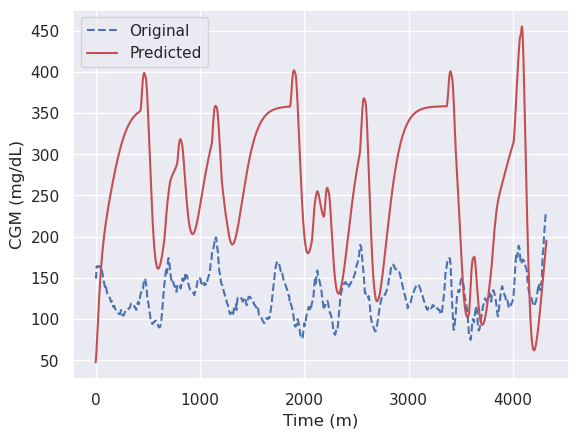

In [10]:
p = adult_params.mean().to_numpy()
pred_t, pred_CGM = output(construct_params(p))
plt.plot(data_t, data_CGM, "b--", label="Original")
plt.plot(pred_t, pred_CGM/3, "r", label="Predicted")
plt.xlabel('Time (m)')
plt.ylabel('CGM (mg/dL)')
plt.legend()
plt.show()

In [11]:
print("Before optimization:")

p = adult_params.mean().to_numpy()
pred_t, pred_CGM = output(construct_params(p))
train_loss = np.sqrt(np.mean((np.log(pred_CGM + 1) - np.log(data_CGM + 1)) ** 2))
print(f"Train Loss: {train_loss}")

test_pred_t, test_pred_CGM = test_output(construct_params(p))
test_loss = np.sqrt(np.mean((np.log(test_pred_CGM + 1) - np.log(test_data_CGM + 1)) ** 2))
print(f"Test Loss: {test_loss}")

Before optimization:
Train Loss: 1.7927901156430415
Test Loss: 1.837763305042319


In [ ]:
# target function
def evaluate(p):
    try:
        pred_t, pred_CGM = output(construct_params(p))
        pred_CGM /= 3
        return [np.sqrt(np.mean((np.log(pred_CGM + 1) - np.log(data_CGM + 1)) ** 2))]
    except:
        return [1e10]

# PSO algorithm setup
p_guess = adult_params.mean().to_numpy()
bounds = (np.zeros_like(p_guess), np.ones_like(p_guess))  # define bounds for each parameter
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}  # set PSO parameters

# instantiate PSO optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=len(p_guess), options=options, bounds=bounds)

# perform optimization
best_cost, best_params = optimizer.optimize(evaluate, iters=500)

# print results
print("Best cost:", best_cost)
print("Best parameters:", best_params)


In [27]:
opt_params = best_params
pred_t, pred_CGM = output(construct_params(opt_params))

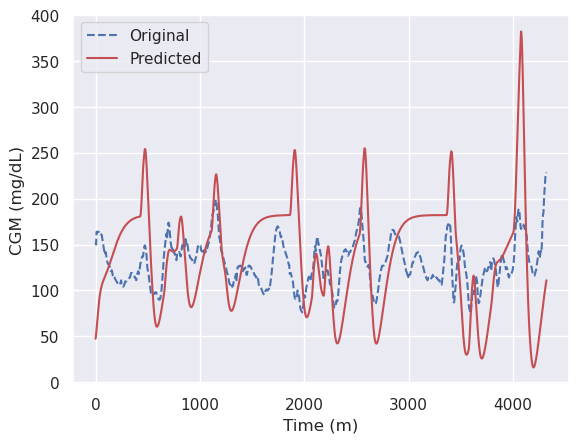

In [28]:
plt.plot(data_t, data_CGM, "b--", label='Original')
plt.plot(pred_t, pred_CGM / 3, "r", label='Predicted')
plt.xlabel('Time (m)')
plt.ylabel('CGM (mg/dL)')
plt.legend()
plt.show()

In [30]:
print("After optimization:")
pred_t, pred_CGM = output(construct_params(opt_params))
train_loss = np.sqrt(np.mean((np.log(pred_CGM/3 + 1) - np.log(data_CGM + 1)) ** 2))
print(f"Train Loss: {train_loss}")

test_pred_t, test_pred_CGM = test_output(construct_params(opt_params))
test_loss = np.sqrt(np.mean((np.log(test_pred_CGM/3 + 1) - np.log(test_data_CGM + 1)) ** 2))
print(f"Test Loss: {test_loss}")

After optimization:
Train Loss: 0.49328371055798237
Test Loss: 0.3727041661239186
